In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Binary Classification to classify breast cancer cells, using transfer learning. 
# Author : [Harirai](https://github.com/Harirai)




Date : 26/05/2020  
We will try different pre-trained models and use transfer learning to predict the class of cells.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import tensorflow as tf
print(tf.__version__)

# Limit output length/
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 1000})


2.2.0


Set our input pipeline. (If you have dataset on drive, mount drive from left sidebar or run the cell below)




In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# To input our dataset easily, we will use `ImageDataGenerator` which requires directory tree as shown :
![dir tree](https://miro.medium.com/max/1682/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)



## Now The fun begins!!  
Let's see some of the images in the dataset.

In [0]:
base_dir = "/content/drive/My Drive/Dataset"
train_dir = "/content/drive/My Drive/Dataset/train"
test_dir  = "/content/drive/My Drive/Dataset/test"
train_b = "/content/drive/My Drive/Dataset/train/Benign"
train_m = "/content/drive/My Drive/Dataset/train/Malignant"
test_b = "/content/drive/My Drive/Dataset/test/Benign"
test_m = "/content/drive/My Drive/Dataset/test/Malignant"

In [0]:
# List all the files in the directory
train_b_fnames = os.listdir(train_b)
train_m_fnames = os.listdir(train_m)

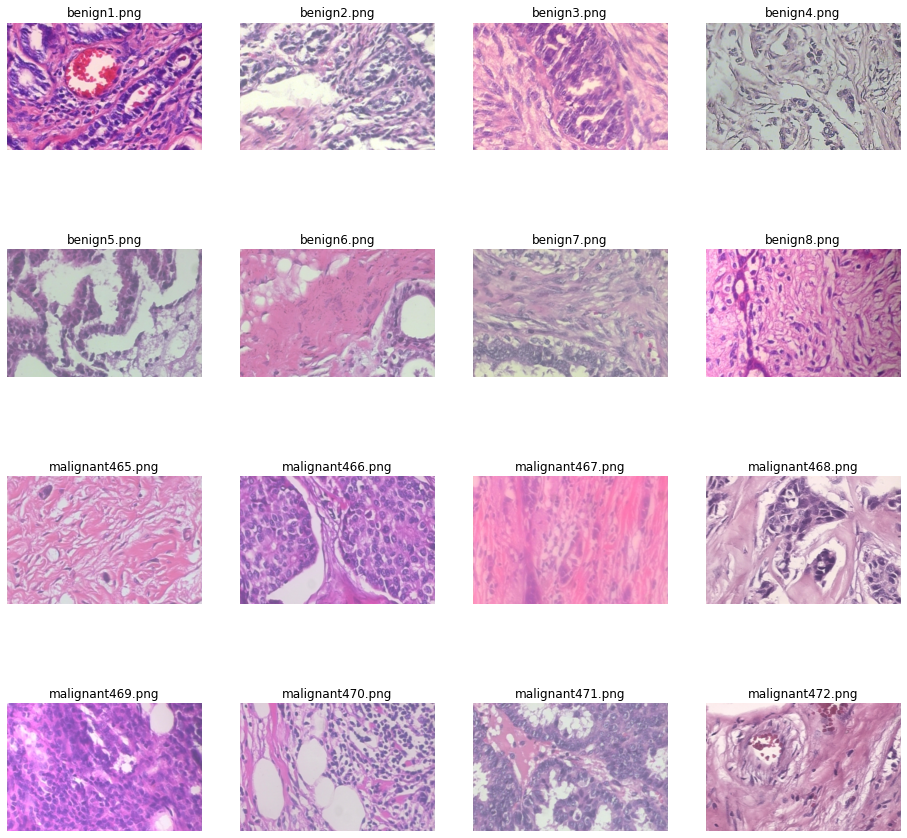

In [15]:
# Let's see some of our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

# 8 images from each class
pic_index+=8

# Benign Images
next_b_pix = [os.path.join(train_b, fname) 
                for fname in train_b_fnames[ pic_index-8:pic_index] 
               ]
# Malignant Images
next_m_pix = [os.path.join(train_m, fname) 
                for fname in train_m_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_b_pix+next_m_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.title(img_path.split("/")[-1])
  plt.imshow(img)

plt.show()



In [0]:
# Function to plot acc and loss vs epochs
def plot_graphs(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()


In [17]:
# We have very few images so we can use Data Augmentation to imporve performance

IMAGE_SIZE = 224 
BATCH_SIZE = 1  # We have very few examples in our dataset, So I thought of using Batch size of 1, you may experiment with it!

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   width_shift_range = 0.05, # image can be shifted 5 % to left or right
                                   height_shift_range = 0.05, # similar
                                   horizontal_flip = True, 
                                   vertical_flip = True,
                                   )

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    class_mode='binary',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    class_mode='binary'
)




Found 1354 images belonging to 2 classes.
Found 659 images belonging to 2 classes.


In [18]:
print(train_generator.class_indices)


{'Benign': 0, 'Malignant': 1}


In [0]:
# Load MobileNetV24

from tensorflow.keras.applications import MobileNetV2
IMG_SHAPE = (IMAGE_SIZE , IMAGE_SIZE , 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [0]:
base_model.trainable = False

In [27]:
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
def my_model(base_model):
  return tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.Conv2D(32, 3, activation='relu'),
                              tf.keras.layers.Dropout(0.2),
                              tf.keras.layers.GlobalAveragePooling2D(),
                              tf.keras.layers.Dense(1, activation='sigmoid')
  ])

In [52]:
model = my_model(base_model)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_6 ( (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 2,626,689
Trainable params: 368,705
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
from tensorflow import keras
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy', 
              keras.metrics.TruePositives(name='tp'),
              keras.metrics.FalsePositives(name='fp'),
              keras.metrics.TrueNegatives(name='tn'),
              keras.metrics.FalseNegatives(name='fn'),
              # keras.metrics.Precision(name='precision'),
              # keras.metrics.Recall(name='recall'),
              # keras.metrics.AUC(name='auc'),
])

In [58]:
epochs = 30
history  = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
)

Epoch 1/30
1354/1354 [==============================] - 49s 36ms/step - loss: 0.6877 - accuracy: 0.6795 - tp: 916.0000 - fp: 426.0000 - tn: 4.0000 - fn: 8.0000 - val_loss: 0.6344 - val_accuracy: 0.7071 - val_tp: 466.0000 - val_fp: 193.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00
Epoch 2/30
1354/1354 [==============================] - 48s 36ms/step - loss: 0.6368 - accuracy: 0.6824 - tp: 924.0000 - fp: 430.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - val_loss: 0.6159 - val_accuracy: 0.7071 - val_tp: 466.0000 - val_fp: 193.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00
Epoch 3/30
1354/1354 [==============================] - 48s 36ms/step - loss: 0.6284 - accuracy: 0.6861 - tp: 918.0000 - fp: 419.0000 - tn: 11.0000 - fn: 6.0000 - val_loss: 0.6065 - val_accuracy: 0.7663 - val_tp: 385.0000 - val_fp: 73.0000 - val_tn: 120.0000 - val_fn: 81.0000
Epoch 4/30
1354/1354 [==============================] - 48s 35ms/step - loss: 0.5626 - accuracy: 0.7489 - tp: 874.0000 - fp: 290.0000 - tn: 140.0000 - 

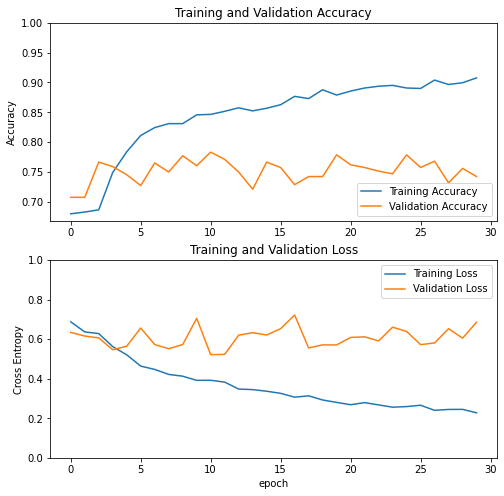

In [59]:
plot_graphs(history)

In [60]:
# Now we can convert our model into Tflite file

saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)  # Save model at specified path

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


# Save labels with corresponding to index
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/fine_tuning/assets
{'Benign': 0, 'Malignant': 1}


In [0]:
# Download the files from left sidebar!!